# ML Part Classification

In [1]:
from jupyter_core.paths import jupyter_path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
from datetime import timedelta

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import lightgbm as lgb # Our ML library

In [3]:
#Cross validation libraries
from sklearn.model_selection import TimeSeriesSplit

In [4]:
import joblib

In [5]:
os.chdir("C:/Users/oleg.kazanskyi/OneDrive - Danaher/Documents/Trading/ML_Part/EOD")
df_compact = pd.read_csv("full_cleaned_dataframe_2023.csv")
df_compact.shape

(689237, 62)

In [6]:
df_compact["date"] = df_compact["date"].apply(pd.to_datetime, errors='coerce')

In [37]:
display(df_compact.sample(10))

,date,days_after_earnings_report,sector,industry,ROE,LTDE,DE,CR,GM,ROA,...,stock,10YBond,10YB_MoM,10YB_YoY,10YB_30MA_Vector,10YB_200MA_Vector,10Y_Val_to_30MA,10Y_Val_to_200MA,Fed_Balance_MoM,Fed_Balance_YoY
97367,2022-12-13,50.0,Financials,Insurance,0.011795,0.431713,0.438925,1.144434,0.492336,0.011795,...,BRO,3.503,-8.513972,145.997191,-0.296312,0.111849,-4.380246,3.671739,-1.107873,-1.986270
525501,2021-01-28,91.0,Industrials,Capital Goods,0.019568,0.168876,0.170172,1.688038,0.168042,0.019568,...,PWR,1.055,12.834225,-33.814304,0.382336,0.264334,0.454976,24.138057,0.011980,78.361896
421265,2022-03-10,14.0,Consumer Staples,"Food, Beverage & Tobacco",0.041169,0.002446,0.002573,4.851545,0.538636,0.041169,...,MNST,2.009,2.709611,32.171053,0.092636,0.234198,4.983574,20.399104,0.423037,17.557578
476189,2018-10-19,85.0,Industrials,Transportation,0.049211,0.013736,0.028998,1.767610,0.292602,0.049211,...,ODFL,3.202,3.859877,37.957777,0.126701,0.079840,2.101811,8.002780,-0.775013,-6.583786
113275,2019-04-04,50.0,Real Estate,Real Estate,0.029264,0.170624,0.299216,1.163841,0.241851,0.029264,...,CBRE,2.510,-7.788391,-10.035842,-0.278266,-0.085743,-0.895086,-13.741813,-0.983271,-10.273240
335691,2021-10-29,8.0,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",0.010860,1.047062,1.054949,0.935424,0.335594,0.010860,...,IQV,1.556,1.104613,86.124402,0.035988,-0.041178,-1.231362,6.395630,1.280779,19.728724
182414,2021-05-14,22.0,Health Care,Health Care Equipment & Services,0.033666,0.432578,0.448544,1.756883,0.402206,0.033666,...,DGX,1.635,-0.061125,164.135703,-0.002088,0.335923,2.383282,24.003670,0.481952,12.927699
16512,2021-05-27,30.0,Consumer Staples,"Food, Beverage & Tobacco",0.013384,0.215306,0.292502,1.581893,0.081935,0.013384,...,ADM,1.610,-0.739827,137.813885,-0.024704,0.302187,-0.546584,19.596894,1.056048,11.359576
417135,2021-12-02,30.0,Materials,Materials,0.018468,0.618596,0.626773,6.654524,0.283760,0.018468,...,MLM,1.449,-6.334842,53.171247,-0.211462,-0.063543,-6.386243,0.143513,1.101204,19.771617
297935,2020-09-18,58.0,Health Care,Health Care Equipment & Services,0.024965,1.895726,1.905765,1.091397,0.842067,0.024965,...,HCA,0.694,2.814815,-60.879369,0.092715,-0.285979,1.479347,1.024135,0.767947,83.746045


In [7]:
df_copy = df_compact.copy()

In [8]:
df_compact.sort_values(by = "date", ascending = False, inplace = True)

In [9]:
print(df_compact.columns)

Index(['date', 'days_after_earnings_report', 'open', 'close', 'sector',
       'industry', 'ROE', 'LTDE', 'DE', 'CR', 'GM', 'ROA', 'DPR',
       'Acc_Rec_Pay_Ration', 'ES', 'DY', 'Piotroski_Score', 'PE', 'PB',
       'PEG_Forward', 'PEG_Backwards', 'EPS_surprise', 'EPS_YoY_Growth',
       'EPS_QoQ_frcst_diff', 'EPS_1Y_exp_Change', 'YoY_ROE', 'YoY_LTDE',
       'YoY_DE', 'YoY_CR', 'YoY_GM', 'YoY_ROA', 'YoY_DPR', 'YoY_AR_Ration',
       'YoY_ES', 'YoY_Piotroski', 'YoY_PE', 'YoY_PB', 'YoY_PEGF', 'YoY_PEGB',
       'YoY_DY', 'EPS_1Y_exp_Change_QoQ', 'future_15dprice_change',
       'future_30dprice_change', 'future_60dprice_change',
       'future_90dprice_change', 'future_120dprice_change',
       'future_150dprice_change', 'VIX_high', 'days_after_crisis', 'VIX_DoD',
       'VIX_WoW', 'VIX_MoM', 'stock', '10YBond', '10YB_MoM', '10YB_YoY',
       '10YB_30MA_Vector', '10YB_200MA_Vector', '10Y_Val_to_30MA',
       '10Y_Val_to_200MA', 'Fed_Balance_MoM', 'Fed_Balance_YoY'],
      dtype='object

In [10]:
df_compact.drop(['close','open'], axis = 1, inplace = True)

df_compact["date"] = df_compact["date"].apply(pd.to_datetime, errors='coerce')
df_compact = df_compact[df_compact['date']>'01/01/2020']
df_compact.shape

In [11]:
#df_compact["date"] = df_compact["date"].apply(pd.to_datetime, errors='coerce')

#Let's take the top 5% as the test df
y_vals = ["future_15dprice_change","future_30dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"]
n_days = [15,30,60,90,120,150]
min_date_train = []

test_dfs_list = []
train_dfs_list = []
full_dfs_list = []

for i, j in enumerate(y_vals):
    n = 5
    num_rows = int(len(df_compact[df_compact[j].notnull()])*(n/100))
    df_full = df_compact[df_compact[j].notnull()]
    df_test = df_compact[df_compact[j].notnull()].iloc[:num_rows]
    df_train = df_compact[df_compact[j].notnull()].iloc[num_rows:]
    
    #Let's remove the data closest to the prediction date to make it close to a real world scenario
    max_date = df_train.date.max()
    max_date = df_train.date.max() - timedelta(days=n_days[i])
    max_date = max_date.strftime('%Y-%m-%d')
    df_train = df_train[df_train.date < max_date]
    
    min_date_train.append(df_train.date.min())

    #We can drop the date column as redundant now
    df_train.drop('date',axis = 1, inplace = True)
    df_test.drop('date',axis = 1, inplace = True)
    df_full.drop('date',axis = 1, inplace = True)
    
    test_dfs_list.append(df_test)
    train_dfs_list.append(df_train)
    full_dfs_list.append(df_full)
    
    
    print(f"Train data size for {n_days[i]} is {df_train.shape[0]} rows")
    print(f"Test data size for {n_days[i]}  is {df_test.shape[0]} rows")

Train data size for 15 is 643887 rows
Test data size for 15  is 34190 rows
Train data size for 30 is 633555 rows
Test data size for 30  is 33919 rows
Train data size for 60 is 613383 rows
Test data size for 60  is 33375 rows
Train data size for 90 is 593726 rows
Test data size for 90  is 32833 rows
Train data size for 120 is 573636 rows
Test data size for 120  is 32292 rows
Train data size for 150 is 552629 rows
Test data size for 150  is 31751 rows


In [12]:
#For the simplicity of analysis we will work with one train dataframe but apply transformations to all the dataframes in the list
df_train = train_dfs_list[0]

cols_num = df_train.select_dtypes([np.number]).columns
cols_str = df_train.select_dtypes('object').columns

### Building a classificator

Ok, we dealt with the numeric prediction of the stock prices movement.

At the same time after seeing the results it made me rethink the purpose.

I am not a trader and the model I am building doesn't have a purpose of daily stocks exchange.

What I want to achieve is to find a stock that with high probability will grow in the next foreseeable future, hold it for a while and sell it with a profit.

Considering this maybe we shouldn't solve the regression problem, but make it a classification problem instead.

To make it the classification problem we would need to replace all price times the prices are going up to 1 and down to zerows.

At the same time I want my model to cover the risks, so let's add the risk factor of loosing a bet and make the range wider.
We will change values to 1 when the price goes up on the level of 3rd percentile for every time range prediction

In [13]:
min_15d_threshold = 4.112
min_30d_threshold = 6.18
min_60d_threshold = 9.25
min_90d_threshold = 11.53
min_120d_threshold = 13.77
min_150d_threshold = 15.95

list_of_thresholds = [min_15d_threshold,min_30d_threshold,min_60d_threshold,min_90d_threshold,min_120d_threshold,min_150d_threshold]

Make the changes to the dataset

In [14]:
targets_all = ["future_15dprice_change","future_30dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"]
periods = ["15d","30d","60d","90d","120d","150d"]
#df_compact_reserve = df_compact.copy()
#Creating a copy of the list with the dataframes
full_dfs_list_copy = []
train_dfs_list_copy = []
test_dfs_list_copy = []
for i, j in enumerate(targets_all):
    full = full_dfs_list[i].copy()
    train = train_dfs_list[i].copy()
    test = test_dfs_list[i].copy()
    full_dfs_list_copy.append(full)
    train_dfs_list_copy.append(train)
    test_dfs_list_copy.append(test)
    

for i, j in enumerate(targets_all):
    #df_compact.loc[df_compact[j]<list_of_thresholds[i], j] = 0
    #df_compact.loc[df_compact[j]>=list_of_thresholds[i], j] = 1
    full_dfs_list_copy[i].loc[full_dfs_list_copy[i][j]<list_of_thresholds[i], j] = 0
    full_dfs_list_copy[i].loc[full_dfs_list_copy[i][j]>=list_of_thresholds[i], j] = 1
    train_dfs_list_copy[i].loc[train_dfs_list_copy[i][j]<list_of_thresholds[i], j] = 0
    train_dfs_list_copy[i].loc[train_dfs_list_copy[i][j]>=list_of_thresholds[i], j] = 1
    test_dfs_list_copy[i].loc[test_dfs_list_copy[i][j]<list_of_thresholds[i], j] = 0
    test_dfs_list_copy[i].loc[test_dfs_list_copy[i][j]>=list_of_thresholds[i], j] = 1

Precision of prediction:0.00, and the AUC is: 0.58
Minimum date in the trade data 2016-09-12 00:00:00


<AxesSubplot: >

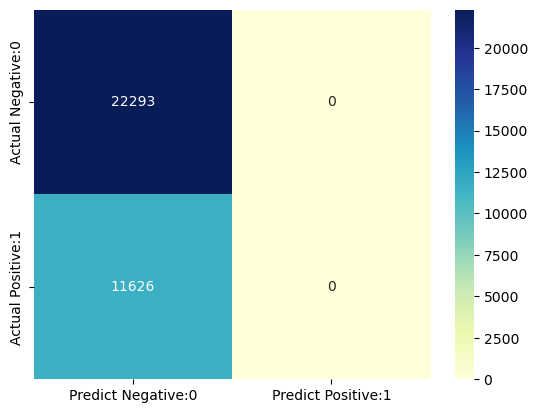

In [15]:
#df_compact_temp = df_compact.drop(["future_30dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"],axis = 1)
#df_compact_temp = df_compact_temp[df_compact_temp["future_15dprice_change"].notna()]
#df_train, df_test = train_test_split(df_compact_temp, test_size=0.2, random_state=42)
df_train, df_test = train_dfs_list_copy[1], test_dfs_list_copy[1]
df_train = df_train.drop(["future_15dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"],axis = 1)
df_train = df_train[df_train["future_30dprice_change"].notna()]
df_test = df_test.drop(["future_15dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"],axis = 1)
df_test = df_test[df_test["future_30dprice_change"].notna()]

#df_train.drop(["stock"], axis = 1, inplace = True)
#df_test.drop(["stock"], axis = 1, inplace = True)
df_train.drop(["stock","industry","days_after_crisis"], axis = 1, inplace = True)
df_test.drop(["stock","industry","days_after_crisis"], axis = 1, inplace = True)

le = LabelEncoder()
le.fit(df_train["sector"])
df_train["sector"] = le.transform(df_train["sector"])
df_test["sector"] = le.transform(df_test["sector"])
#le.fit(df_train["industry"])
#df_train["industry"] = le.transform(df_train["industry"])
#df_test["industry"] = le.transform(df_test["industry"])

#Creating the x, y variables 
y_train = df_train["future_30dprice_change"]
y_test = df_test["future_30dprice_change"]

x_train = df_train.drop("future_30dprice_change", axis = 1)
x_test = df_test.drop("future_30dprice_change", axis = 1)

lgbm = lgb.LGBMClassifier(random_state=42,n_jobs = 5, n_estimators = 50)
#lgbm.fit(x_train, y_train, categorical_feature=['sector'])
lgbm.fit(x_train, y_train)

#predicting on test set
ypred=lgbm.predict(x_test)
ypred_prob = lgbm.predict_proba(x_test)[:, 1]

#calculating accuracy
precision = round(precision_score(y_test, ypred, pos_label=1, average='binary'),2)
AUC = round(roc_auc_score(y_test, ypred_prob),2)
print(f"Precision of prediction:{precision:0.2f}, and the AUC is: {AUC:0.2f}")
print(f"Minimum date in the trade data {min_date_train[1]}")

cm = confusion_matrix(y_test, ypred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Positive:1'], 
                                 index=['Actual Negative:0', 'Actual Positive:1'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')


## Let's analyze the results

In [16]:
#df_current_test = df_copy.copy()

In [17]:
#df_copy = df_current_test.copy()

In [18]:
y_test = y_test.to_frame()
ypred_prob = pd.DataFrame(ypred_prob)
y_test.loc[:,'pred_proba'] = ypred_prob.values

In [19]:
def add_proba_column(dataframe, old_col, new_col, threshold):
    dataframe.loc[dataframe[old_col] >= threshold, new_col] = 1
    dataframe.loc[dataframe[old_col] < threshold, new_col] = 0
    return dataframe

In [20]:
y_test = add_proba_column(y_test,"pred_proba","pred_55",0.55)
y_test = add_proba_column(y_test,"pred_proba","pred_60",0.60)
y_test = add_proba_column(y_test,"pred_proba","pred_65",0.65)
y_test = add_proba_column(y_test,"pred_proba","pred_70",0.70)
y_test = add_proba_column(y_test,"pred_proba","pred_75",0.75)
y_test = add_proba_column(y_test,"pred_proba","pred_80",0.80)

In [21]:
y_test = y_test[["pred_55","pred_60","pred_65","pred_70","pred_75","pred_80"]]

Joining the test train data classes

In [22]:
df_copy = df_copy.join(y_train, how='left', rsuffix='train')

Joining the predicted classes

In [23]:
df_copy = df_copy.join(y_test, how='left', rsuffix='test')

In [24]:
df_copy.columns

Index(['date', 'days_after_earnings_report', 'open', 'close', 'sector',
       'industry', 'ROE', 'LTDE', 'DE', 'CR', 'GM', 'ROA', 'DPR',
       'Acc_Rec_Pay_Ration', 'ES', 'DY', 'Piotroski_Score', 'PE', 'PB',
       'PEG_Forward', 'PEG_Backwards', 'EPS_surprise', 'EPS_YoY_Growth',
       'EPS_QoQ_frcst_diff', 'EPS_1Y_exp_Change', 'YoY_ROE', 'YoY_LTDE',
       'YoY_DE', 'YoY_CR', 'YoY_GM', 'YoY_ROA', 'YoY_DPR', 'YoY_AR_Ration',
       'YoY_ES', 'YoY_Piotroski', 'YoY_PE', 'YoY_PB', 'YoY_PEGF', 'YoY_PEGB',
       'YoY_DY', 'EPS_1Y_exp_Change_QoQ', 'future_15dprice_change',
       'future_30dprice_change', 'future_60dprice_change',
       'future_90dprice_change', 'future_120dprice_change',
       'future_150dprice_change', 'VIX_high', 'days_after_crisis', 'VIX_DoD',
       'VIX_WoW', 'VIX_MoM', 'stock', '10YBond', '10YB_MoM', '10YB_YoY',
       '10YB_30MA_Vector', '10YB_200MA_Vector', '10Y_Val_to_30MA',
       '10Y_Val_to_200MA', 'Fed_Balance_MoM', 'Fed_Balance_YoY',
       'future_30dpr

In [25]:
print(len(df_copy))
print(len(y_train))
print(len(ypred))

689237
633555
33919


In [26]:
df_copy.drop(['future_15dprice_change',   'future_60dprice_change',
       'future_90dprice_change', 'future_120dprice_change',
       'future_150dprice_change'], axis = 1, inplace = True)

In [27]:
stocks_with_buys = list(df_copy[df_copy['pred_55'] == 1].stock.unique())
print(stocks_with_buys)

[]


In [28]:
df_copy = df_copy[df_copy['stock'].isin(stocks_with_buys)]

In [29]:
#df_copy = df_copy[df_copy.stock == 'ABBV']

In [30]:
df_copy = df_copy[df_copy['pred_55'].notnull()]

In [31]:
df_copy["date"] = df_copy["date"].apply(pd.to_datetime, errors='coerce')

In [32]:
df_copy.set_index('date', inplace = True)

In [33]:
df_copy.stock[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [35]:
df_copy

,days_after_earnings_report,open,close,sector,industry,ROE,LTDE,DE,CR,GM,...,10Y_Val_to_200MA,Fed_Balance_MoM,Fed_Balance_YoY,future_30dprice_changetrain,pred_55,pred_60,pred_65,pred_70,pred_75,pred_80
date,,,,,,,,,,,,,,,,,,,,,


defining a function to build a double y axis chart

In [ ]:
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m-%Y')


def dual_axis(df_input, col1_name, col2_name):
    COLOR_1 = "#69b3a2" #green
    COLOR_2 = "#3399e6"
    COLOR_3 = "#e29b8c" #orange
    
    df = df_input.copy()
    df['shifted'] = df[col1_name].shift(22)
    fig, ax1 = plt.subplots(figsize=(60, 30))
    ax2 = ax1.twinx()
    
    ax1.plot(df.index, df[col1_name], color=COLOR_1, lw=3)
    ax1.plot(df.index, df['shifted'], color=COLOR_3, lw=3)
        
    ax2.plot(df.index, np.zeros(len(df)), color='red', lw=2)
    ax2.plot(df.index, df[col2_name], color=COLOR_2, lw=4)
    
    ax1.set_xlabel("Date", fontsize=20)
    ax1.set_ylabel(col1_name, color=COLOR_1, fontsize=14)
    ax1.tick_params(axis="y", labelcolor=COLOR_1)
    ax1.tick_params(axis="x", labelsize=25)
    
    ax2.set_ylabel(col2_name, color=COLOR_2, fontsize=14)
    ax2.tick_params(axis="y", labelcolor=COLOR_2)
    
    ax1.xaxis.set_major_formatter(myFmt)
    ax2.xaxis.set_major_formatter(myFmt)
    
    fig.suptitle(f"{df.stock[0]} ticker. {col1_name} and {col2_name}", fontsize=30)
    fig.autofmt_xdate()
    plt.show()

In [ ]:
for i in stocks_with_buys:
    #dual_axis(df_copy[ (df_copy.stock == i) & (df_copy.index > datetime(2019, 1, 1)) & (df_copy.index < datetime(2021, 1, 1))], 'close', 'pred_55')
    dual_axis(df_copy[ df_copy.stock == i], 'close', 'pred_55')

The results are promising

## Cross validation time data

In [38]:
df_train.sort_index(ascending = False, inplace = True)
df_train.reset_index(inplace = True)
df_train.drop('index', axis = 1, inplace = True)

display(df_train.head(2))
df_train.shape

,days_after_earnings_report,sector,ROE,LTDE,DE,CR,GM,ROA,DPR,Acc_Rec_Pay_Ration,...,VIX_MoM,10YBond,10YB_MoM,10YB_YoY,10YB_30MA_Vector,10YB_200MA_Vector,10Y_Val_to_30MA,10Y_Val_to_200MA,Fed_Balance_MoM,Fed_Balance_YoY
0,39.0,5,0.031115,1.168815,1.40459,1.955491,0.64013,0.031115,0.218487,4.12987,...,20.800781,2.213,-5.143592,36.352434,-0.179169,-0.035393,-0.701913,-7.844555,-0.246252,-0.231934
1,40.0,5,0.031115,1.168815,1.40459,1.955491,0.64013,0.031115,0.218487,4.12987,...,-0.801425,2.207,-5.034423,36.571782,-0.175003,-0.034149,-0.798973,-8.100816,-0.246252,-0.231934


(633555, 51)

In [39]:
y_train = df_train["future_30dprice_change"]
x_train = df_train.drop("future_30dprice_change", axis = 1)
x_train.index

RangeIndex(start=0, stop=633555, step=1)

In [40]:
y_train = df_train["future_30dprice_change"]
x_train = df_train.drop("future_30dprice_change", axis = 1)

tscv = TimeSeriesSplit(n_splits=5, test_size=30000, gap=round(11050,0))
#tscv = TimeSeriesSplit(n_splits=5, test_size=30000, gap=round(2210,0))

aucs = []
precs = []

for i, (train_index, val_idx) in enumerate(tscv.split(df_train)):
        print(f"======= Fold {i} ========")
        #print(f"  Train: index={min(train_index)} : {max(train_index)}")
        #print(f"  Test:  index={min(val_idx)} : {max(val_idx)}")

        X_tr = x_train.loc[train_index]
        y_tr = y_train.loc[train_index]

        X_val = x_train.loc[val_idx]
        y_val = y_train.loc[val_idx] 

        # Fit Model on Train
        clf = lgb.LGBMClassifier(random_state=42,n_jobs = 5, n_estimators = 50)     
        clf.fit(X_tr, y_tr)
        pred = clf.predict(X_val)
        #print(pred.sum())
        #if pred.sum() == 0:
            
        pred_prob = clf.predict_proba(X_val)[:, 1]
        acc_score = accuracy_score(y_val, pred)
        precision = precision_score(y_val, pred, pos_label=1, average='binary')
        auc_score = roc_auc_score(y_val, pred_prob)
        
        print(
        f"Our accuracy on the validation set is {acc_score:0.4f}, precision is {precision:0.4f}, and AUC is {auc_score:0.4f}"
        )
        aucs.append(auc_score)
        oof_auc = np.mean(aucs)
        precs.append(precision)
        precs_auc = np.mean(precs)
        print(f'Our out of fold AUC score is {oof_auc:0.4f} and precision is {precs_auc:0.4f} \n\n')

======= Fold 0 ========
Our accuracy on the validation set is 0.7857, precision is 0.6751, and AUC is 0.7666
Our out of fold AUC score is 0.7666 and precision is 0.6751 


======= Fold 1 ========
Our accuracy on the validation set is 0.7856, precision is 0.6648, and AUC is 0.7743
Our out of fold AUC score is 0.7704 and precision is 0.6699 


======= Fold 2 ========
Our accuracy on the validation set is 0.7823, precision is 0.6657, and AUC is 0.7564
Our out of fold AUC score is 0.7658 and precision is 0.6685 


======= Fold 3 ========
Our accuracy on the validation set is 0.7790, precision is 0.7536, and AUC is 0.8017
Our out of fold AUC score is 0.7747 and precision is 0.6898 


======= Fold 4 ========
Our accuracy on the validation set is 0.7758, precision is 0.6916, and AUC is 0.7679
Our out of fold AUC score is 0.7734 and precision is 0.6902 




In [ ]:
#Creating the x, y variables 
y_train = df_train["future_30dprice_change"]
y_test = df_test["future_30dprice_change"]

x_train = df_train.drop("future_30dprice_change", axis = 1)
x_test = df_test.drop("future_30dprice_change", axis = 1)

lgbm = lgb.LGBMClassifier(random_state=42,n_jobs = 5, n_estimators = 50)
lgbm.fit(x_train, y_train)#, categorical_feature=['sector'])

#predicting on test set
ypred=lgbm.predict(x_test)
ypred_prob = lgbm.predict_proba(x_test)[:, 1]

#calculating accuracy
precision = round(precision_score(y_test, ypred, pos_label=1, average='binary'),2)
AUC = round(roc_auc_score(y_test, ypred_prob),2)
print(f"Precision of prediction:{precision:0.2f}, and the AUC is: {AUC:0.2f}")

cm = confusion_matrix(y_test, ypred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Positive:1'], 
                                 index=['Actual Negative:0', 'Actual Positive:1'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

#### We got increase of precision from 49% in the regression model to 50% in classification model.
I know that we are kind of comparing apples to oranges, but with a target we have in mind this is a great result without model tuning and little efforts.

#### Let's find the best timeframe to invest testing the classification for all the prediction length

In [ ]:
precisions_list = []
AUC_list = []
feature_importances = []
list_of_classification_models = []
list_of_test_df = []
list_of_ypred = []
list_of_ypred_proba = []

for j, i in enumerate(targets_all):
    remove_redundant_list = list(targets_all)
    remove_redundant_list.remove(i)

    #df_compact_temp = df_compact.drop(remove_redundant_list,axis = 1)
    #df_compact_temp = df_compact_temp[df_compact_temp[i].notna()]
    #df_train, df_test = train_test_split(df_compact_temp, test_size=0.2, random_state=42)
    df_train, df_test = train_dfs_list_copy[j], test_dfs_list_copy[j]
    df_train = df_train.drop(remove_redundant_list,axis = 1)
    df_train = df_train[df_train[i].notna()]
    df_test = df_test.drop(remove_redundant_list,axis = 1)
    df_test = df_test[df_test[i].notna()]

    df_train.drop(["stock","industry","days_after_crisis"], axis = 1, inplace = True)
    df_test.drop(["stock","industry","days_after_crisis"], axis = 1, inplace = True)
    list_of_test_df.append(df_test)

    le = LabelEncoder()
    le.fit(df_train["sector"])
    df_train["sector"] = le.transform(df_train["sector"])
    df_test["sector"] = le.transform(df_test["sector"])

    #Creating the x, y variables 
    y_train = df_train[i]
    y_test = df_test[i]

    x_train = df_train.drop(i, axis = 1)
    x_test = df_test.drop(i, axis = 1)

    lgbm = lgb.LGBMClassifier(random_state=42,n_jobs = 5, n_estimators = 50)
    lgbm.fit(x_train, y_train, categorical_feature=['sector'])
    list_of_classification_models.append(lgbm)

    #predicting on test set
    ypred=lgbm.predict(x_test)
    ypred_prob = lgbm.predict_proba(x_test)[:, 1]
    list_of_ypred.append(ypred)
    list_of_ypred_proba.append(ypred_prob)

    #calculating accuracy
    precision = round(precision_score(y_test, ypred, pos_label=1, average='binary'),2)
    AUC = round(roc_auc_score(y_test, ypred_prob),2)
    print("\n"*3+"="*50+"\n"+f"Precision of prediction for {periods[j]}:{precision:0.2f}")
    print("\n"+f"AUC of this classifier for {periods[j]}:{AUC:0.2f}")
    precisions_list.append(precision)
    AUC_list.append(AUC)

    cm = confusion_matrix(y_test, ypred)
    cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Positive:1'], 
                                     index=['Actual Negative:0', 'Actual Positive:1'])
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    plt.show()
    
    feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,x_train.columns)), columns=['Value','Feature'])
    feature_imp["Value, %"] = (feature_imp['Value'] / feature_imp['Value'].sum()) * 100
    print(feature_imp.sort_values(by='Value, %', ascending=False)[:20])
    feature_importances.append(feature_imp[["Feature", "Value, %"]])

### Let's summarize the precision level we got for every record

In [ ]:
precisions_list = [round(x*100,2) for x in precisions_list]
AUC_list = [round(x*100,2) for x in AUC_list]

precisions_compare_dt = {"Precision achieved":precisions_list,"AUC achieved":AUC_list}
precisions_compare_df = pd.DataFrame(precisions_compare_dt, index = periods)
precisions_compare_df.index.name = "Forecasted Period, days"

print(precisions_compare_df)

The max precision we achieved is for 30days prediction timeframe and is 69%.

We also need to remember that to be secure we are not predictiong when the price goes up, but when it goes up for more than 6% in case of 30 days and 4.1% in case of 15 days prediction.

I trully wonder what might be the total precision if we compare it with the zero level.
We have indexes untouched so lets compare.

In [ ]:
# first let's create a new column with the 30days prediction classifier: 0 when price dropped and 1 when it's increased.
df_30d_train = train_dfs_list[1]
df_30d_test = test_dfs_list[1]

df_30d_train.loc[df_30d_train["future_30dprice_change"]<0.1, "30dprice_change_classification"] = 0
df_30d_train.loc[df_30d_train["future_30dprice_change"]>=0.1, "30dprice_change_classification"] = 1
df_30d_test.loc[df_30d_test["future_30dprice_change"]<0.1, "30dprice_change_classification"] = 0
df_30d_test.loc[df_30d_test["future_30dprice_change"]>=0.1, "30dprice_change_classification"] = 1

In [ ]:
print(df_30d_test.shape)
len(list_of_ypred[1])

In [ ]:
#let's join prediction result to the test dataframe and get indexes
df_prediction = df_30d_test.copy()
df_prediction["prediction"] = list_of_ypred[1]
df_prediction = df_prediction["prediction"]

In [ ]:
#let's connect prediction result by indexes to the main dataframe
df_30_compare =  df_30d_test[["future_30dprice_change","30dprice_change_classification"]]
df_30_compare = df_30_compare.join(df_prediction, how = 'left')
df_30_compare = df_30_compare[df_30_compare["prediction"].notnull()]

In [ ]:
# Now let's see how many negative values were really predicted as positive
df_30_compare = df_30_compare[["30dprice_change_classification","prediction"]].groupby("30dprice_change_classification").sum()
df_30_compare["Value, %"] = (df_30_compare['prediction'] / df_30_compare['prediction'].sum()) * 100
df_30_compare

## 86% PRECISION!!!!!

We achieved a great precision with a tested results.

The only issue here is the number of required deals is close to 2500.

The length of the dataset is about 3 months of data, that means implementing the strategy requires making about 800 deals a month.
To make outcome feasible a minimum bet should be about 1000USD so the starting capital should be 800K USD.

It is not a feasible amount for me personally.

I want to find out if increasing of the threshold that our model uses to make a classification about the model, can actually reduce the number of deals and increase the precision even further.

### Let's try to increase the threshold and check if we can get higher

In [ ]:
#let's join prediction result to the test dataframe and get indexes
df_prediction = df_30d_test.copy()
df_prediction["prediction"] = list_of_ypred[1]
df_prediction["prediction_proba"] = list_of_ypred_proba[1]
df_prediction = df_prediction[["prediction","prediction_proba"]]

#let's connect prediction result by indexes to the main dataframe
df_30_compare =  df_30d_test[["future_30dprice_change","30dprice_change_classification"]]
df_30_compare = df_30_compare.join(df_prediction, how = 'left')
df_30_compare = df_30_compare[df_30_compare["prediction"].notnull()]

Creating a function that adds new conditinal columns to the dataset

In [ ]:

def add_proba_column(dataframe, old_col, new_col, threshold):
    dataframe.loc[dataframe[old_col] >= threshold, new_col] = 1
    dataframe.loc[dataframe[old_col] < threshold, new_col] = 0
    return dataframe

Adding columns

In [ ]:
df_30_compare = add_proba_column(df_30_compare,"prediction_proba","pred_55",0.55)
df_30_compare = add_proba_column(df_30_compare,"prediction_proba","pred_60",0.60)
df_30_compare = add_proba_column(df_30_compare,"prediction_proba","pred_65",0.65)
df_30_compare = add_proba_column(df_30_compare,"prediction_proba","pred_70",0.70)
df_30_compare = add_proba_column(df_30_compare,"prediction_proba","pred_75",0.75)
df_30_compare = add_proba_column(df_30_compare,"prediction_proba","pred_80",0.80)

Add a function to display pivot tables based on a column

In [ ]:
def pivot_precision(dataframe, real_class, prediction_class):
    dataframe = dataframe[[real_class,prediction_class]].groupby(real_class).sum()
    dataframe["Value, %"] = (dataframe[prediction_class] / dataframe[prediction_class].sum()) * 100
    display(dataframe)
    print('\n')

In [ ]:
predicitons_list_str = ["pred_55","pred_60","pred_65","pred_70","pred_75","pred_80"]

for i in predicitons_list_str:
    pivot_precision(df_30_compare, "30dprice_change_classification", i)

Great, we got 2 last options with the threshold above 75% that allow us to make it works with the much lower budgets.

I will works with a model with a modified threshold at 80% level as it allows to work with about 25K USD budget.

Let's save the model and label encoder to the joblib files

Let's relearn our model based on all he data before saving

In [ ]:
feature_importances = []
list_of_classification_models = []

list_of_ypred = []
list_of_ypred_proba = []

for j, i in enumerate(targets_all):
    remove_redundant_list = list(targets_all)
    remove_redundant_list.remove(i)

    df_full = full_dfs_list_copy[j]
    df_full = df_full.drop(remove_redundant_list,axis = 1)
    df_full = df_full[df_full[i].notna()]


    df_full.drop(["stock","industry","days_after_crisis"], axis = 1, inplace = True)

    le = LabelEncoder()
    le.fit(df_full["sector"])
    df_full["sector"] = le.transform(df_full["sector"])

    #Creating the x, y variables 
    y_train = df_full[i]
    x_train = df_full.drop(i, axis = 1)


    lgbm = lgb.LGBMClassifier(random_state=42,n_jobs = 5, n_estimators = 50)
    lgbm.fit(x_train, y_train, categorical_feature=['sector'])
    list_of_classification_models.append(lgbm)
   
    feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,x_train.columns)), columns=['Value','Feature'])
    feature_imp["Value, %"] = (feature_imp['Value'] / feature_imp['Value'].sum()) * 100
    print(feature_imp.sort_values(by='Value, %', ascending=False)[:20])
    feature_importances.append(feature_imp[["Feature", "Value, %"]])

#Saving the label encoder
filename = 'C:/Users/oleg.kazanskyi/OneDrive - Danaher/Documents/Trading/Models/label_encoder_012023.joblib'
joblib.dump(le, filename)

#Saving the models
for i, period in enumerate(periods):
    folder = 'C:/Users/oleg.kazanskyi/OneDrive - Danaher/Documents/Trading/Models/'
    full_path = os.path.join(folder,period+"_model.joblib")
    joblib.dump(list_of_classification_models[i], full_path)